In [1]:
!pip install requests pandas

## Data Preparation for Analysis


In [2]:
import requests

API_KEY = ""
url = f"https://api.nasa.gov/insight_weather/?api_key={API_KEY}&feedtype=json&ver=1.0"

response = requests.get(url)

if response.status_code == 200:
    weather_data = response.json()
    print("Successfully fetched Mars weather data.")

    print("Top-level keys in the JSON response:")
    print(weather_data.keys())

    print("Sample data structure:")

    if 'sol_keys' in weather_data and weather_data['sol_keys']:
        first_sol_key = weather_data['sol_keys'][0]
        print(f"Data for first Sol ({first_sol_key}):")
        display(weather_data[first_sol_key])
    elif weather_data:

         first_key = list(weather_data.keys())[0]
         print(f"Data for key '{first_key}':")
         display(weather_data[first_key])
    else:
        print("The JSON response is empty or has an unexpected structure.")


else:
    print(f"Error fetching data: Status Code {response.status_code}")
    print(f"Response Text: {response.text}")

Successfully fetched Mars weather data.
Top-level keys in the JSON response:
dict_keys(['675', '676', '677', '678', '679', '680', '681', 'sol_keys', 'validity_checks'])
Sample data structure:
Data for first Sol (675):


{'AT': {'av': -62.314, 'ct': 177556, 'mn': -96.872, 'mx': -15.908},
 'First_UTC': '2020-10-19T18:32:20Z',
 'HWS': {'av': 7.233, 'ct': 88628, 'mn': 1.051, 'mx': 22.455},
 'Last_UTC': '2020-10-20T19:11:55Z',
 'Month_ordinal': 10,
 'Northern_season': 'early winter',
 'PRE': {'av': 750.563, 'ct': 887776, 'mn': 722.0901, 'mx': 768.791},
 'Season': 'fall',
 'Southern_season': 'early summer',
 'WD': {'0': {'compass_degrees': 0.0,
   'compass_point': 'N',
   'compass_right': 0.0,
   'compass_up': 1.0,
   'ct': 254},
  '1': {'compass_degrees': 22.5,
   'compass_point': 'NNE',
   'compass_right': 0.382683432365,
   'compass_up': 0.923879532511,
   'ct': 1},
  '10': {'compass_degrees': 225.0,
   'compass_point': 'SW',
   'compass_right': -0.707106781187,
   'compass_up': -0.707106781187,
   'ct': 8618},
  '11': {'compass_degrees': 247.5,
   'compass_point': 'WSW',
   'compass_right': -0.923879532511,
   'compass_up': -0.382683432365,
   'ct': 1912},
  '12': {'compass_degrees': 270.0,
   'compass_

In [3]:
import pandas as pd

sols_data = []
for sol_key in weather_data['sol_keys']:
    sol_info = weather_data[sol_key]
    if 'PRE' in sol_info and 'HWS' in sol_info and 'First_UTC' in sol_info:
        sols_data.append({
            'sol': int(sol_key),
            'earth_date': sol_info['First_UTC'],
            'average_pressure': sol_info['PRE']['av'],
            'average_wind_speed': sol_info['HWS']['av']
        })

df_weather = pd.DataFrame(sols_data)

df_weather['earth_date'] = pd.to_datetime(df_weather['earth_date'])

print("Processed Mars Weather Data:")
display(df_weather.head())

print("\nDataFrame Info:")
display(df_weather.info())

Processed Mars Weather Data:


,sol,earth_date,average_pressure,average_wind_speed
0,675,2020-10-19 18:32:20+00:00,750.563,7.233
1,676,2020-10-20 19:11:55+00:00,749.090,8.526
2,677,2020-10-21 19:51:31+00:00,748.698,7.887
3,678,2020-10-22 20:31:06+00:00,743.741,5.246
4,679,2020-10-23 21:10:41+00:00,744.529,5.565



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   sol                 7 non-null      int64              
 1   earth_date          7 non-null      datetime64[ns, UTC]
 2   average_pressure    7 non-null      float64            
 3   average_wind_speed  7 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 356.0 bytes


None

## First Research Question and Hypotheses (Boloro 23229538)

**Research Question:** Is there a connection between how high or low the air pressure is and how fast the wind blows on Mars? Do lower pressures usually mean faster winds?

**Null Hypothesis (H₀):** There is no clear connection between the average air pressure and the average wind speed on Mars. They don't consistently go up or down together.

**Alternative Hypothesis (H₁):** There *is* a connection: when the average air pressure goes down, the average wind speed tends to go up.

T-statistic: -2.035, P-value: 1.022e-01
Fail to Reject Null Hypothesis: No significant relationship detected.


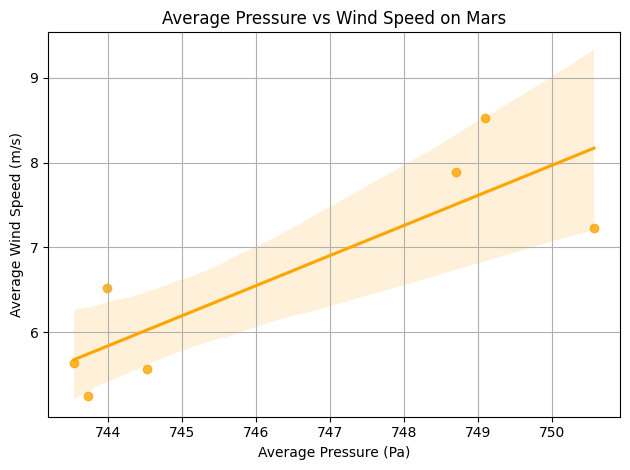

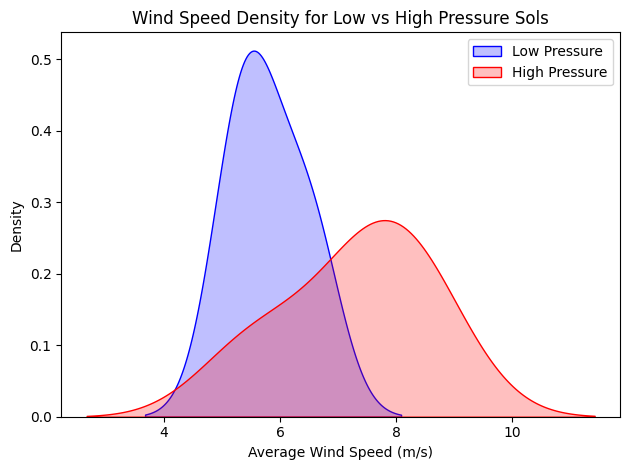

In [4]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

API_KEY = ""
url = f"https://api.nasa.gov/insight_weather/?api_key={API_KEY}&feedtype=json&ver=1.0"

response = requests.get(url)
mars_data = response.json()

sol_keys = mars_data["sol_keys"]
records = []

for sol in sol_keys:
    info = mars_data[sol]
    records.append({
        "Sol": int(sol),
        "Average_Pressure": info.get("PRE", {}).get("av"),
        "Average_Wind_Speed": info.get("HWS", {}).get("av"),
    })

data = pd.DataFrame(records).dropna()

median_pressure = data["Average_Pressure"].median()
low_pressure = data[data["Average_Pressure"] < median_pressure]["Average_Wind_Speed"]
high_pressure = data[data["Average_Pressure"] >= median_pressure]["Average_Wind_Speed"]

t_stat, p_value = stats.ttest_ind(low_pressure, high_pressure, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3e}")

if p_value < 0.05:
    print("Reject Null Hypothesis: Lower pressure corresponds to higher wind speeds.")
else:
    print("Fail to Reject Null Hypothesis: No significant relationship detected.")

sns.regplot(data=data, x="Average_Pressure", y="Average_Wind_Speed", color="orange")
plt.title("Average Pressure vs Wind Speed on Mars")
plt.xlabel("Average Pressure (Pa)")
plt.ylabel("Average Wind Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.kdeplot(low_pressure, fill=True, color="blue", label="Low Pressure")
sns.kdeplot(high_pressure, fill=True, color="red", label="High Pressure")
plt.title("Wind Speed Density for Low vs High Pressure Sols")
plt.xlabel("Average Wind Speed (m/s)")
plt.legend()
plt.tight_layout()
plt.show()

#Summary of findings on RQ 1

Combining the results from the statistical test and the two visualizations, the analysis suggests that, for this dataset, there is no significant relationship or difference in average wind speed based on atmospheric pressure levels on Mars. While the scatterplot hinted at a potential weak negative trend, the t-test and density plots indicate that any observed difference is not statistically significant and the distributions of wind speeds for low and high pressure are largely overlapping.

## Second Research Question and Hypotheses (Danish 23229514)

**Research Question:** How much does the weather jump around (how stable is it) over just two Martian days compared to over five Martian days? We will look at both air pressure and wind speed to see if their stability is different over these time periods.

**Null Hypothesis (H₀):** The average amount the weather jumps around is pretty much the same whether you look at it over 2 days or 5 days.

**Alternative Hypothesis (H₁):** The average amount the weather jumps around over 2 days is different than over 5 days.

## Displaying the Dataframe

In [5]:
import pandas as pd
display(df_weather.head())

,sol,earth_date,average_pressure,average_wind_speed
0,675,2020-10-19 18:32:20+00:00,750.563,7.233
1,676,2020-10-20 19:11:55+00:00,749.090,8.526
2,677,2020-10-21 19:51:31+00:00,748.698,7.887
3,678,2020-10-22 20:31:06+00:00,743.741,5.246
4,679,2020-10-23 21:10:41+00:00,744.529,5.565


## Calculate stability for 2-sol windows (Wind Speed)


In [6]:
import pandas as pd

two_sol_stability_data = []
for i in range(len(df_weather) - 1):
    window = df_weather.iloc[i:i+2]
    stability = window['average_wind_speed'].std()
    sols_in_window = tuple(window['sol'].tolist())
    two_sol_stability_data.append({'Window Sols': sols_in_window, 'Wind Speed Stability (Std Dev)': stability})

df_two_sol_stability = pd.DataFrame(two_sol_stability_data)

print("Stability for 2-Sol Windows:")
display(df_two_sol_stability)

Stability for 2-Sol Windows:


,Window Sols,Wind Speed Stability (Std Dev)
0,"(675, 676)",0.914289
1,"(676, 677)",0.451841
2,"(677, 678)",1.867469
3,"(678, 679)",0.225567
4,"(679, 680)",0.673166
5,"(680, 681)",0.625790


## Calculate stability for 5-sol windows (Wind Speed)


In [14]:
five_sol_stability_data = []
for i in range(len(df_weather) - 4):
    window = df_weather.iloc[i:i+5]
    stability = window['average_wind_speed'].std()
    sols_in_window = tuple(window['sol'].tolist())
    five_sol_stability_data.append({'Window Sols': sols_in_window, 'Wind Speed Stability (Std Dev)': stability})

df_five_sol_stability = pd.DataFrame(five_sol_stability_data)

print("Stability for 5-Sol Windows:")
display(df_five_sol_stability)

Stability for 5-Sol Windows:


,Window Sols,Wind Speed Stability (Std Dev)
0,"(675, 676, 677, 678, 679)",1.435836
1,"(676, 677, 678, 679, 680)",1.428938
2,"(677, 678, 679, 680, 681)",1.069783


## Calculating 2-sol windows stability (Air Pressure)

In [8]:
import pandas as pd

two_sol_stability_pressure_data = []
for i in range(len(df_weather) - 1):
    window = df_weather.iloc[i:i+2]
    stability = window['average_pressure'].std()
    sols_in_window = tuple(window['sol'].tolist())
    two_sol_stability_pressure_data.append({'Window Sols': sols_in_window, 'Average Pressure Stability (Std Dev)': stability})

df_two_sol_stability_pressure = pd.DataFrame(two_sol_stability_pressure_data)

print("Stability for 2-Sol Windows (Average Pressure):")
display(df_two_sol_stability_pressure)

Stability for 2-Sol Windows (Average Pressure):


,Window Sols,Average Pressure Stability (Std Dev)
0,"(675, 676)",1.041568
1,"(676, 677)",0.277186
2,"(677, 678)",3.505128
3,"(678, 679)",0.557200
4,"(679, 680)",0.381131
5,"(680, 681)",0.311127


## Calculating 5-sol windows stability (Air Pressure)



In [15]:
five_sol_stability_pressure_data = []
for i in range(len(df_weather) - 4):
    window = df_weather.iloc[i:i+5]
    stability = window['average_pressure'].std()
    sols_in_window = tuple(window['sol'].tolist())
    five_sol_stability_pressure_data.append({'Window Sols': sols_in_window, 'Average Pressure Stability (Std Dev)': stability})

df_five_sol_stability_pressure = pd.DataFrame(five_sol_stability_pressure_data)

print("Stability for 5-Sol Windows (Average Pressure):")
display(df_five_sol_stability_pressure)

Stability for 5-Sol Windows (Average Pressure):


,Window Sols,Average Pressure Stability (Std Dev)
0,"(675, 676, 677, 678, 679)",3.006146
1,"(676, 677, 678, 679, 680)",2.652068
2,"(677, 678, 679, 680, 681)",2.153852


## T-Testing for both Air Pressure and Wind Speed

In [10]:
from scipy import stats
import pandas as pd

two_sol_stability_pressure_series = df_two_sol_stability_pressure['Average Pressure Stability (Std Dev)']
five_sol_stability_pressure_series = df_five_sol_stability_pressure['Average Pressure Stability (Std Dev)']

ttest_result_pressure_stability = stats.ttest_ind(two_sol_stability_pressure_series, five_sol_stability_pressure_series, equal_var=False)

print("Independent Samples t-test results for Average Pressure Stability (2-sol vs 5-sol windows):")
print(f"Test Statistic: {ttest_result_pressure_stability.statistic}")
print(f"P-value: {ttest_result_pressure_stability.pvalue}")

Independent Samples t-test results for Average Pressure Stability (2-sol vs 5-sol windows):
Test Statistic: -2.801423250275807
P-value: 0.027715439443485104


In [11]:
from scipy import stats
import pandas as pd

two_sol_stability_wind_series = df_two_sol_stability['Wind Speed Stability (Std Dev)']
five_sol_stability_wind_series = df_five_sol_stability['Wind Speed Stability (Std Dev)']

ttest_result_wind_stability = stats.ttest_ind(two_sol_stability_wind_series, five_sol_stability_wind_series, equal_var=False)

print("Independent Samples t-test results for Average Wind Speed Stability (2-sol vs 5-sol windows):")
print(f"Test Statistic: {ttest_result_wind_stability.statistic}")
print(f"P-value: {ttest_result_wind_stability.pvalue}")

Independent Samples t-test results for Average Wind Speed Stability (2-sol vs 5-sol windows):
Test Statistic: -1.965235164792803
P-value: 0.0912819959446995


## Visualizing the distributions


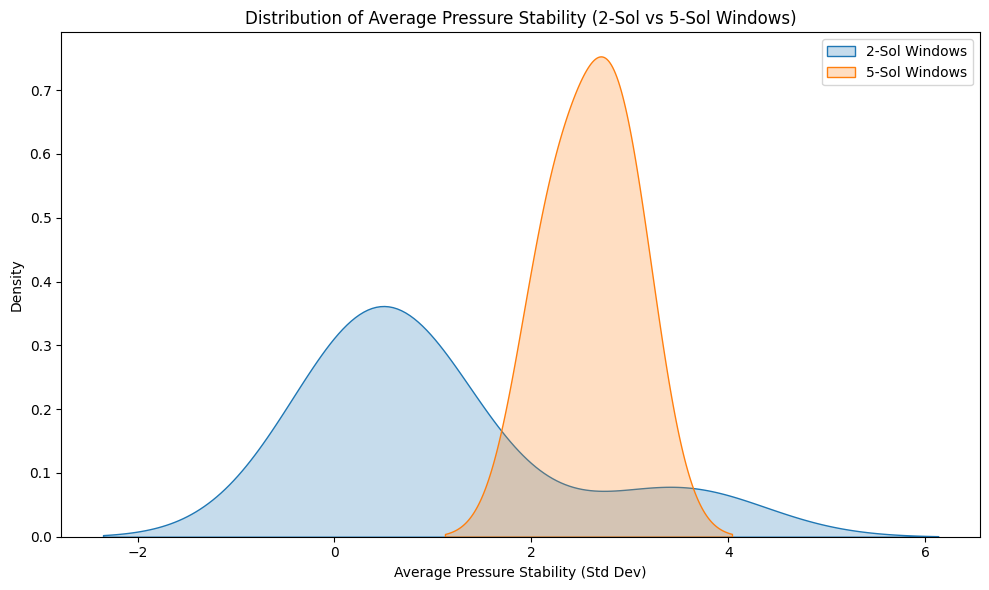

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.kdeplot(x=two_sol_stability_pressure_series, fill=True, label='2-Sol Windows')
sns.kdeplot(x=five_sol_stability_pressure_series, fill=True, label='5-Sol Windows')
plt.title('Distribution of Average Pressure Stability (2-Sol vs 5-Sol Windows)')
plt.xlabel('Average Pressure Stability (Std Dev)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

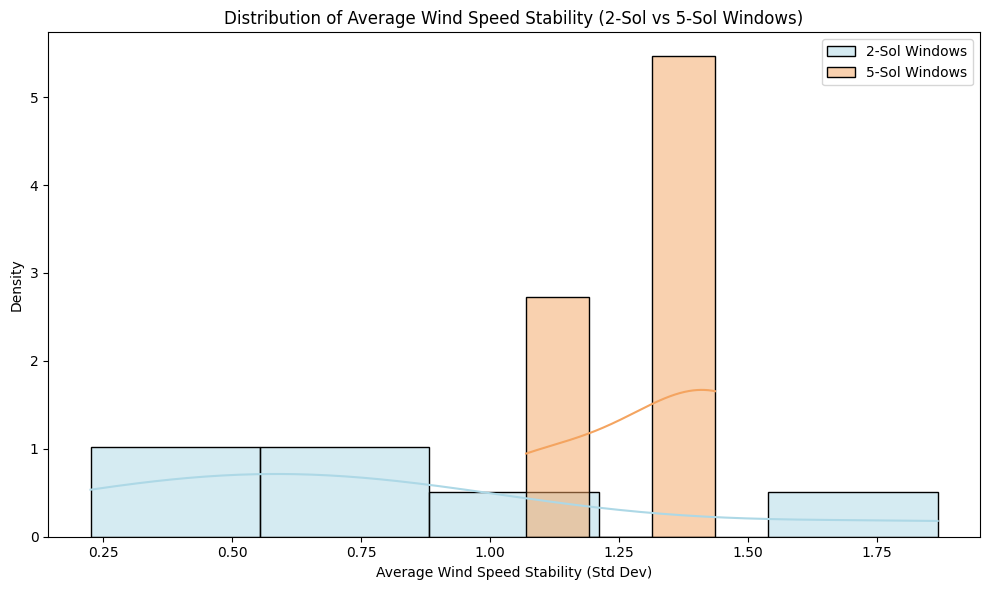

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))
sns.histplot(x=two_sol_stability_wind_series, color="lightblue", label='2-Sol Windows', kde=True, stat="density", common_norm=False)
sns.histplot(x=five_sol_stability_wind_series, color="sandybrown", label='5-Sol Windows', kde=True, stat="density", common_norm=False)

plt.title('Distribution of Average Wind Speed Stability (2-Sol vs 5-Sol Windows)')
plt.xlabel('Average Wind Speed Stability (Std Dev)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

#Summary of findings on RQ 2

Based on our analysis of this short period of Mars weather data:
1. The stability of air pressure appears to be different when looking at 2-day periods versus 5-day periods.
2. The stability of wind speed, however, did not show a significant difference between these two time periods with our data.

This suggests that different aspects of the weather on Mars might behave uniquely in terms of how much they vary over short versus slightly longer time scales.

#Reflection and Conclusion

Martian weather might behave uniquely compared to Earth, but it's important to remember our analysis used very limited data based on what the public API gave us. Future studies with more extensive data are needed to confirm these observations and build a more complete picture of Mars's atmosphere.